<a href="https://colab.research.google.com/github/ExCaLBBR/ExCaLBBR_Projects/blob/main/SocioenvironmentalGeometry/code/ConceptGeo_AnalysisNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Concept Geometry analysis pipeline 
Created by: <b>Roberto Vargas </b><br>
Adapted from Octave by: <b>Nahom Mossazghi </b><br>
<br>
<b>Pipeline includes:</b><br>
*   Data restructuring: Sorting accoring to word list
*   Regression predicting pair differences


<br>
<br>

In [49]:
#@title Install dependancies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from scipy import stats 
from itertools import combinations
import math
import statsmodels as sm
from sklearn.linear_model import LinearRegression
import csv
from tqdm import tqdm
import networkx as nx

In [36]:
#@title Define utility functions
def weightedHeatmap(PairData, words, PlotHM):
        
    '''
    Restructure RT into matrix data structure
    
    '''
    
    Wmat = np.zeros((len(words),len(words))) 
    t = 0
    z = 0
    
    for i in range(len(words)):
        for j in range(len(words)):
            
            if i == j:
                Wmat[i,j] = np.NaN
            
            elif j > i:
                Wmat[i,j] = PairData[t]
                Wmat[j,i] = PairData[t]            
                t += 1  
                
                
    if PlotHM == 1:
        plt.imshow(Wmat, cmap='RdBu')
        plt.colorbar()
        plt.xticks(range(len(words)), words, rotation='vertical')
        plt.yticks(range(len(words)), words)
        plt.show()
        
    return Wmat
        
def ccbi_randperm(ntimes, nperm):
    
    '''
      p = ccbi_randperm(nitems,nperm)
      Parameters: number of items, number of random permutations
      Output: a matrix with nperm rows;
      Each row is an index of permuted item positions.
    
      returns a matrix (n,nitems)
      each row is a random permutation of nitems (labelled 1:nitems)
      produces n such permutations
      the random seed is changed at every call
      
    '''
    
    p = np.zeros((nperm, ntimes))        
    for i in range(nperm):
        p[i,:] = np.random.permutation(ntimes)
        
    return p
                 

def splitHalf_Reliability(dat, perm):
    """
    Compute the reliability within a measure
    This analysis splits the data into 2 halfs and then averages the similarity structure
    This analysis is repeated
    
    """
    pSplit = ccbi_randperm(dat.shape[1], perm)

    rho = []
    for p in range(perm):
        # Split data
        if dat.shape[1] % 2 == 0:  # is even
            frstHalf = dat.iloc[:, pSplit[p, :(pSplit.shape[1]//2)]]
            scndHalf = dat.iloc[:, pSplit[p, (pSplit.shape[1]//2):]]

        elif dat.shape[1] % 2 == 1:  # is odd
            frstHalf = dat.iloc[:, pSplit[p, :int(np.floor(pSplit.shape[1]/2))]]
            scndHalf = dat.iloc[:, pSplit[p, int(np.ceil(pSplit.shape[1]/2)):]]
        # Avg dist of each half
        avgFrstHalf = frstHalf.mean(axis=1)
        avgScndHalf = scndHalf.mean(axis=1)

        # Correlate halves
        rhoI = np.corrcoef(avgFrstHalf, avgScndHalf)[0,1]

        rho.append(rhoI)
    
    rho = np.mean(rho)

    return rho
        


def regPairDiff(dumX, cov, Y, perm):
    
    '''
    
    Predict pair differences among a binary category in Y
 	dumX is a dummy code variable being used to predict Y
 	cov is a matrix of covariates included in the model
 	Y is a continuous vector 
 	perm is the number of permutations used to compare against the observed beta
    Dimensions of duX, cov, and Y should all align
    
    '''    
    
    # Generate the permutations
    pComb = ccbi_randperm(len(dumX),perm)
    
    # Generate constant
    con = np.ones(len(dumX))
    con = con.reshape(con.shape[0], 1)
    
    # Estimate observed beta
    dumX =  dumX.reshape(dumX.shape[0],1)
    cov = cov.reshape(cov.shape[0],1)
    xModel = np.concatenate((con, dumX, cov), axis=1)
    beta_obs, _, _, _ = np.linalg.lstsq(xModel, Y, rcond=None)
    betaObs = beta_obs[1]
    
    betaPerm = []
    
    for p in range(perm):
        pCombi = pComb.astype(int)
        xPermModel = np.concatenate((con, dumX[pCombi[p,:]], cov), axis=1)
        bPerm, _, _, _ = np.linalg.lstsq(xPermModel, Y, rcond=None)
        betaPerm.append(bPerm[1])
        
    if betaObs > 0:
        
        nBbeyond =  len(np.where(np.array(betaPerm) > betaObs)[0])
        pval = nBbeyond/perm
 	    
        
    elif betaObs < 0:
 	    nBbeyond = len([x for x in betaPerm if x < betaObs])
 	    pval = nBbeyond/perm
        
    else:
        raise ValueError('observed beta is exactly equal to 0')
        
    return betaObs, pval, betaPerm

In [3]:
#Data path
path = 'https://github.com/ExCaLBBR/ExCaLBBR_Projects/raw/main/SocioenvironmentalGeometry/data/'

# Load Demographic PRaM data
datDemo = pd.read_csv (path + 'demographic.csv', header=1)
datPRaM = pd.read_csv (path + 'df_taskPRaM.csv', header=0)
pairLab = pd.read_csv (path + 'PRaM_pairLabels.csv', header=None)

#remove misc row
datDemo = datDemo.drop(labels=0, axis=0)
datDemo = datDemo.reset_index(drop=True)
datPRaM = datPRaM.drop(['Participant Private ID'], axis=1)
datPRaM = datPRaM.reset_index(drop=True)

#Sort pairs accoring to prefered combination
words = ['police', 'firefighter', 'neighbors(yours)', 'conservatives(political)', 'liberals(political)', 'healthcare', 'voting', 'immigration', 'religion', 'science', 'anger', 'fear', 'joy', 'love', 'sadness', 'trust']
combinations_list = [list(c) for c in combinations(words, 2)]


In [4]:
# re-organize the dataframe according to the word combination
wPairLabel = []
x = []                  #index orders are saved as list
for i in range(len(combinations_list)):
    
    # Extract pair rating
    idx0 = pairLab[pairLab.iloc[:,1].str.contains(combinations_list[i][0].replace('(', r'\(').replace(')', r'\)'))].index
    idx1 = pairLab[pairLab.iloc[:,2].str.contains(combinations_list[i][1].replace('(', r'\(').replace(')', r'\)'))].index
    pIndx = idx0.intersection(idx1)
    
    # Extract pair label
    wPairLabeli = combinations_list[i][0] + '-' + combinations_list[i][1]
    wPairLabel.append(wPairLabeli)
    x.append(pIndx[0])

# Pair label rating    
datPRaM_conSort = datPRaM.iloc[:,x]   
datPRaM_conSort = datPRaM_conSort.rename(columns=dict(zip(datPRaM_conSort.columns, wPairLabel)))    
wPairLabel = pd.DataFrame(wPairLabel)    

In [5]:
# Convert to distance matrix
Wmat = np.zeros((len(words), len(words)))    

t = 0
z = 0
for i in range(len(words)):
    for j in range(len(words)):   
        if i == j:
            Wmat[i,j] = np.NaN
        elif j > i:
            Wmat[i,j] = datPRaM_conSort.iloc[t,0]
            Wmat[j,i] = datPRaM_conSort.iloc[t,0]
        
            t += 1

In [6]:
#Indx racial groups 
raceCol = datDemo.columns.get_loc('raceEth_v2')
bIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('Black or African American')].index
wIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('White')].index 
    
bPRaM = datPRaM_conSort.iloc[bIndx,:]
wPRaM = datPRaM_conSort.iloc[wIndx,:]

print(f'N of Black Sample = ', len(bIndx))
print(f'N of White Sample = ', len(wIndx))

N of Black Sample =  279
N of White Sample =  294


In [7]:
# Average pair distance
avgBSim = np.mean(bPRaM, axis=0)
avgWSim = np.mean(wPRaM, axis=0)

#Participant-wise normalization
bPRaMz = stats.zscore(bPRaM, axis=0)  
wPRaMz = stats.zscore(wPRaM, axis=0)   
    
# Compute mean normalized association
bPRaMz_avg = np.mean(bPRaMz, axis=0);
wPRaMz_avg = np.mean(wPRaMz, axis=0);

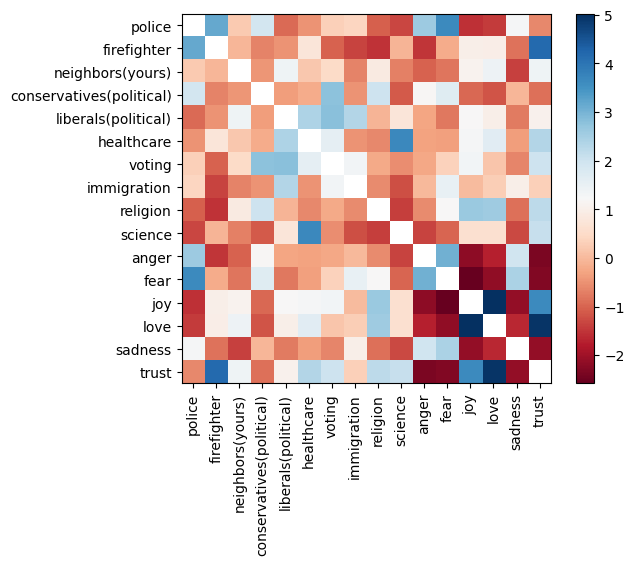

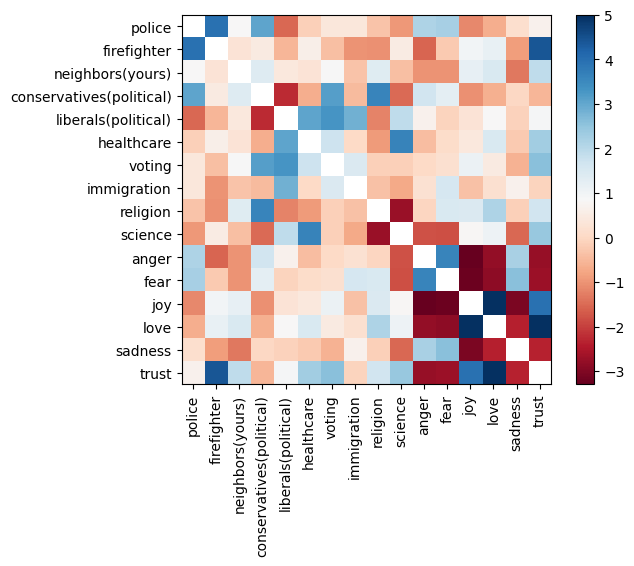

In [8]:
# Generate distance matricies
bPRaM_Weights = weightedHeatmap(avgBSim, words,1); # Compute association matrix for Black participants
wPRaM_Weights = weightedHeatmap(avgWSim, words,1); # Compute association matrix for White participants   
    

In [48]:
# Splithalf Reliability
perm = 10000
rhobPRaM = splitHalf_Reliability(bPRaMz, perm)
rhowPRaM = splitHalf_Reliability(wPRaMz, perm)
print(f'PRaM reliability for Black sample:', round(rhobPRaM,2))
print(f'PRaM reliability for White sample:', round(rhowPRaM,2))

PRaM reliability for Black sample: 0.94
PRaM reliability for White sample: 0.92


Mean age for Black sample: 37.14 (SD = 11.31 )
Mean age for White sample: 41.53 (SD = 12.41 )


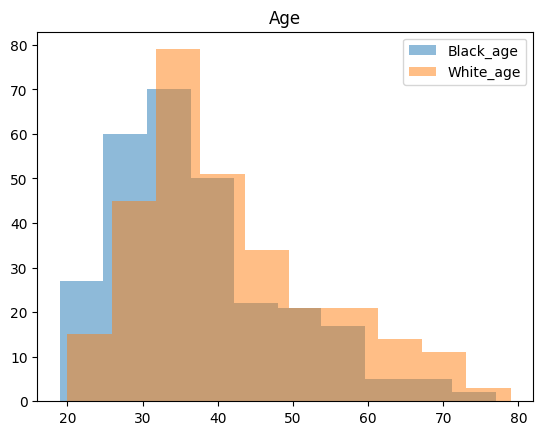

In [9]:
# Isolate Age variable and create concatonated vector
ageCol = datDemo.columns.get_loc('age')
bAge = datDemo.iloc[bIndx,ageCol]
wAge = datDemo.iloc[wIndx,ageCol]
bAge = bAge.replace(1984, 38)
Age = np.concatenate([bAge, wAge])

bAge_mean = np.mean(bAge)
wAge_mean = np.mean(wAge)
bAge_sd = np.std(bAge)
wAge_sd = np.std(wAge)

print(f'Mean age for Black sample:', round(bAge_mean,2), '(SD =', round(bAge_sd,2), ')')
print(f'Mean age for White sample:', round(wAge_mean,2), '(SD =', round(wAge_sd,2), ')')

# Plot age histograms
plt.hist(bAge, 
         alpha=0.5,
         label='Black_age')
  
plt.hist(wAge, 
         alpha=0.5,
         label='White_age')
  
plt.legend(loc='upper right')
plt.title('Age')
plt.show()



100%|██████████| 120/120 [00:03<00:00, 31.52it/s]


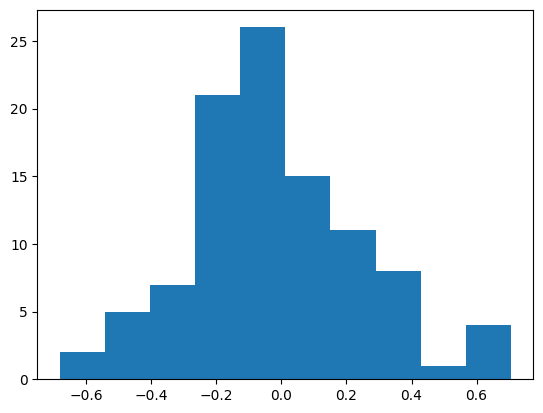

In [77]:
#Measure Word-Pair differences across groups
#Dummy coded linear regression

blackCode = np.concatenate([np.ones(len(bIndx)), np.zeros(len(wIndx))])
perm = 100 
    
# Concatonate data Needs to be structured as Pair-by-participants
# Original
PRaM_cat = np.concatenate([bPRaM, wPRaM])


bObsPairsPRaM = []
pPairsPRaM = []
z = 0

#Iterate through concept-pairs
for i in tqdm(range(len(wPairLabel))):

    
    # Isolate pair data 
    yPRaM = PRaM_cat[:,i]
    
    #Dummy coded linear regression
    #Compared against permuted distribution
    betaObs_PRaM, pval_PRaM, betaPerm1 = regPairDiff(blackCode, Age, yPRaM, perm)

    #Update output
    bObsPairsPRaM.append(betaObs_PRaM)
    pPairsPRaM.append(pval_PRaM)
    if i == 0:
      plt.hist(betaPerm1)

#Implement FDR correction
FDR_sig = sm.stats.multitest.fdrcorrection(pPairsPRaM, alpha=0.05, method='indep', is_sorted=False)

Graphical representation of conceptual associations for: Black sample


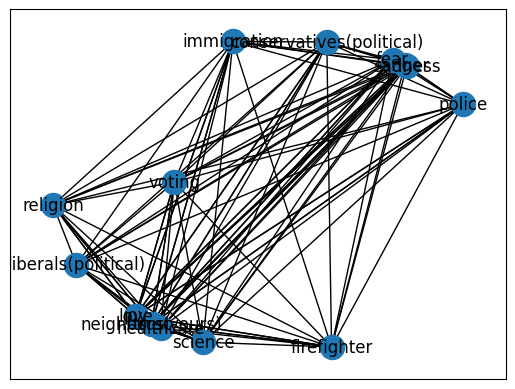

In [123]:
#Generate Graph of conceptual associations for Black Sample
avgBSimT = tuple(avgBSim)

print("Graphical representation of conceptual associations for: Black sample")
G = nx.Graph()

for e in range(len(combinations_list)):
  G.add_edge(combinations_list[e][0], combinations_list[e][1], weight=avgBSimT[e])
pos = nx.spring_layout(G, iterations = 10000)
nx.draw_networkx(G,pos)


Graphical representation of conceptual associations for: White sample


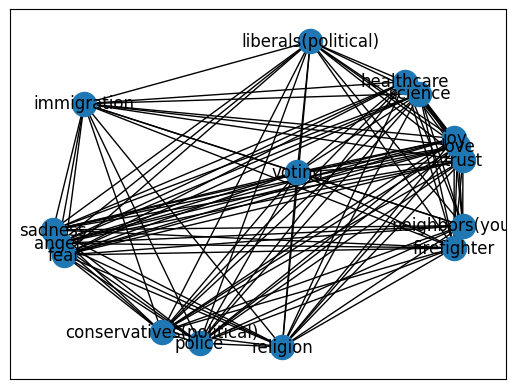

In [124]:
#Generate Graph of conceptual associations for White Sample
G = nx.Graph()
avgWSimT = tuple(avgWSim)

print("Graphical representation of conceptual associations for: White sample")
for e in range(len(combinations_list)):
  G.add_edge(combinations_list[e][0], combinations_list[e][1], weight=avgWSimT[e])
pos = nx.spring_layout(G, iterations = 10000)
nx.draw_networkx(G,pos)

In [ ]:
#Compute representational 